# CO416 - Machine Learning for Imaging

# Tutorial 3 - Neural Networks: From Numpy to Pytorch

**Aims of this tutorial**:
- Introduce you Pytorch, a library made for working with neural networks.
- Implement Multi-Layer Perceptrons (MLP), starting from linear regression.
- Implement a small Convolutional Neural Network (CNN).
Along the way you will implement forward and back-propagation as well as stochastic gradient descent.

It may look long, but it should be easy to complete. Understanding and familiarizing yourselves with the core points of this tutorial and the Pytorch library is of **very high importance in order to be able to follow the next tutorials and Coursework \#2**. Invest some time to study and understand it, and don't hesitate to ask if you don't understand something.

**Prerequisites**:
- Familiar with python and numpy.
- Familiar with linear regression and MNIST.


**Notes**:
- Docs for Pytorch's functions you will need:  
https://pytorch.org/docs/stable/tensors.html  
https://pytorch.org/docs/stable/nn.html  
- Some helper functions for loading and plotting data are given in `./utils` folder. They will be used out of the box below.

## Preliminary: Loading and refreshing MNIST

We will be using MNIST data again in this tutorial. Because the images are small, the database allows small networks to be quickly trained using CPU. Anything larger afterwards will require GPUs.

Important point to understand is the structure of the loaded data. Especially the **shape** of the loaded numpy arrays, because we need to manipulate it carefully, when processing it with neural networks.

Lets load and inspect the data...

In [24]:
# -*- coding: utf-8 -*-
# The below is for auto-reloading external modules after they are changed, such as those in ./utils.
# Issue: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import numpy as np
from utils.data_utils import get_mnist # Helper function. Use it out of the box.

# Constants
DATA_DIR = './mnist' # Location we will keep the data.
SEED = 111111

# If datasets are not at specified location, they will be downloaded.
train_imgs, train_lbls = get_mnist(data_dir=DATA_DIR, train=True, download=False)
test_imgs, test_lbls = get_mnist(data_dir=DATA_DIR, train=False, download=False)

print("[train_imgs] Type: ", type(train_imgs), "|| Shape:", train_imgs.shape, "|| Data type: ", train_imgs.dtype )
print("[train_lbls] Type: ", type(train_lbls), "|| Shape:", train_lbls.shape, "|| Data type: ", train_lbls.dtype )
print('Class labels in train = ', np.unique(train_lbls))

print("[test_imgs] Type: ", type(test_imgs), "|| Shape:", test_imgs.shape, " || Data type: ", test_imgs.dtype )
print("[test_lbls] Type: ", type(test_lbls), "|| Shape:", test_lbls.shape, " || Data type: ", test_lbls.dtype )
print('Class labels in test = ', np.unique(test_lbls))

S_tr_samples = train_imgs.shape[0] # S hereafter. Number of training samples in database.
print('num of train_imgs sample ', S_tr_samples)
H_height = train_imgs.shape[1] # H hereafter
print('sample height ',H_height)
W_width = train_imgs.shape[2] # W hereafter
print('sample weight ',W_width)

C_classes = len(np.unique(train_lbls)) # C hereafter
print('num of labels ',C_classes)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[train_imgs] Type:  <class 'numpy.ndarray'> || Shape: (60000, 28, 28) || Data type:  uint8
[train_lbls] Type:  <class 'numpy.ndarray'> || Shape: (60000,) || Data type:  int16
Class labels in train =  [0 1 2 3 4 5 6 7 8 9]
[test_imgs] Type:  <class 'numpy.ndarray'> || Shape: (10000, 28, 28)  || Data type:  uint8
[test_lbls] Type:  <class 'numpy.ndarray'> || Shape: (10000,)  || Data type:  int16
Class labels in test =  [0 1 2 3 4 5 6 7 8 9]
num of train_imgs sample  60000
sample height  28
sample weight  28
num of labels  10


Above we see that data have been loaded in *numpy arrays*.    
Arrays with images have **shape ( S = number of samples, H = height, W = width )**.  
Arrays with labels have **shape ( S = number of samples)**, holding one integer per image, the digit's class.

MNIST comprises of a **train set (S_tr = 60000) images** and a **test set (S_te = 10000) images**.  
Model development uses the train set. Finally, a model is evaluated on the test set.

Lets plot a few of them in one collage to have a better look...

Plotting image of shape:  (280, 280)


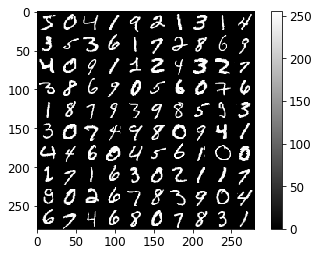

In [17]:
%matplotlib inline
from utils.plotting import plot_grid_of_images # Helper functions, use out of the box.
plot_grid_of_images(train_imgs[0:100], n_imgs_per_row=10)

Notice that the intensities in the images take **values from 0 to 255**.

## Preliminary: Data pre-processing

A first step in almost all pipelines is to pre-process the data, to make them more appropriate for a model.

Below, we will perform 3 points:  
a) Change the labels from an integer representation to a **one-hot representation** of the **C=10 classes**. (Lecture 5, slide 16.)  
b) Normalize the **intensities** in the images (from 0-255) to have a **zero-mean** and **unary standard deviation**. (Lecture 5, slide 68)  
c) **Vectorise the 2D images into 1D vectors for the MLP**, which only gets vector-input per sample. The CNN later will use the original 2D images.  

In [19]:
# a) Change representation of labels to one-hot vectors of length C=10. (Lecture 5, slide 16.)
train_lbls_onehot = np.zeros(shape=(train_lbls.shape[0], C_classes ) )
train_lbls_onehot[ np.arange(train_lbls_onehot.shape[0]), train_lbls ] = 1
test_lbls_onehot = np.zeros(shape=(test_lbls.shape[0], C_classes ) )
test_lbls_onehot[ np.arange(test_lbls_onehot.shape[0]), test_lbls ] = 1
print("BEFORE: [train_lbls]        Type: ", type(train_lbls), "|| Shape:", train_lbls.shape, " || Data type: ", train_lbls.dtype )
print("AFTER : [train_lbls_onehot] Type: ", type(train_lbls_onehot), "|| Shape:", train_lbls_onehot.shape, " || Data type: ", train_lbls_onehot.dtype )

print('for example ',train_lbls_onehot[0])

BEFORE: [train_lbls]        Type:  <class 'numpy.ndarray'> || Shape: (60000,)  || Data type:  int16
AFTER : [train_lbls_onehot] Type:  <class 'numpy.ndarray'> || Shape: (60000, 10)  || Data type:  float64
for example  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Plotting image of index: [ 0 ]
Class label for this image is:  5
One-hot label representation: [ [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] ]
Plotting image of shape:  (28, 28)


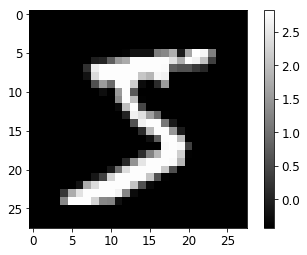

In [20]:
# b) Normalize image intensities of the database to have mean=0 and std=1 across. (Lecture 5, slide 68)
# This commonly facilitates learning:
# - A zero-centered signal with small magnitude allows avoiding exploding/vanishing problems easier.
# - Features of arbitrary & heterogeneous ranges are harder to learn how to model.
from utils.data_utils import normalize_int_whole_database # Helper function. Used outside the box.
train_imgs = normalize_int_whole_database(train_imgs)
test_imgs = normalize_int_whole_database(test_imgs)

# Lets plot one image.
from utils.plotting import plot_image # Helper function, use out of the box.
index = 0 # Try any, up to 60000
print("Plotting image of index: [", index, "]")
print("Class label for this image is: ", train_lbls[index])
print("One-hot label representation: [", train_lbls_onehot[index], "]")
plot_image(train_imgs[index])
# Notice the magnitude of intensities. Black is now negative and white is positive float.

In [7]:
# c) Flatten the images, from 2D matrices to 1D vectors. MLPs take feature-vectors as input, not 2D images.
train_imgs_flat = train_imgs.reshape([train_imgs.shape[0], -1]) # Preserve 1st dim (N = num samples), flatten others.
test_imgs_flat = test_imgs.reshape([test_imgs.shape[0], -1])
print("Shape of numpy array holding the training database:")
print("Original : [S, H, W] = [", train_imgs.shape , "]")
print("Flattened: [S, H*W]  = [", train_imgs_flat.shape , "]")

Shape of numpy array holding the training database:
Original : [S, H, W] = [ (60000, 28, 28) ]
Flattened: [S, H*W]  = [ (60000, 784) ]


## Task 1: Stochastic Gradient Descent for Training Neural Nets

(Lecture 5, slides 48)

Below you are given the main training function, gradient_descent. This will be called by all following parts of the tutorial.  
The function takes a model and data and performs an iteration of gradient descent. Every few steps, it will also predict the testing data and report accuracy.

If the training database is large, processing the whole database per iteration can be very slow. An efficient alternative is **stochastic** gradient descent, where a training batch is randomly sampled per iteration.

In the below, change the code to make gradient descent stochastic, by sampling a **random** batch per iteration instead of constantly the same training samples.

(*Task 1 can be completed independently from Task 2. Try both before and after, to observe the different behaviour.*)


In [23]:
from utils.plotting import plot_train_progress

def get_random_batch(train_imgs, train_lbls, batch_size, rng):
    # rng: numpy random number generator
    # train_imgs: Images for training. Numpy array of shape [S, H, W]
    # train_lbls: Labels of the training images. Numpy array [S], one integer for each of S samples.
    # batch_size: integer. Size that the batch should have.
    
    ####### TODO: Sample a random batch of images for training. Fill in the blanks (???) ######### 
    #indices = rng.randint(low=??????, high=train_imgs.shape[???????], size=?????????, dtype='int32')
    # ???????
    indices = rng.randint(low=1, high=train_imgs.shape[0], size=5, dtype='int32')# high=train_imgs.shape[0] = 600000
    indices = range(0, batch_size)
    ##############################################################################################
    
    train_imgs_batch = train_imgs[indices]
    train_lbls_batch = train_lbls[indices]
    return [train_imgs_batch, train_lbls_batch]

def gradient_descent(net, loss_func, update_params_func, rng,
                     train_imgs, train_lbls, test_imgs, test_lbls,
                     batch_size, learning_rate, total_iters, iters_per_test=-1 ):
    # net: Instance of a model. See classes: MLP_Numpy, MLP_Torch, MLP_Torch_Autograd, CNN_Torch_Autograd.
    # loss_func: Function that computes the loss. See functions: cross_entropy_numpy/torch.
    # update_params_func: Function performing SGD parameter updates. See: grad_descent_update_numpy/torch/autograd
    # rng: numpy random number generator
    # train_imgs: The training images. Numpy array, shape [S_tr, H, W]
    # test_imgs: Save as above, for testing images. [S_te, H, W]
    # train_lbls: One hot representation of labels corresponding to train_imgs. Numpy array, shape [S_tr, C]
    # test_lbls: As above, but for testing data. [S_te, C]
    # batch_size: Size N of the batch that should be processed per SGD iteration by a model.
    # learning_rate: self explanatory.
    # total_iters: how many iterations in total to perform.
    # iters_per_test: Integer. Every that many iterations the model predicts the test data and accuracy is reported.
    values_to_plot = {'loss':[], 'acc_train': [], 'acc_test': []}
    
    for t in range(total_iters):
        # Sample batch for this SGD iteration
        train_imgs_batch, train_lbls_batch = get_random_batch(train_imgs, train_lbls, batch_size, rng)
        
        # Forward pass
        y_pred = net.forward_pass(train_imgs_batch)

        # Compute loss: Cross Entropy
        y_real = train_lbls_batch
        loss = loss_func(y_pred, y_real)

        # Backwards pass. Compute gradients.
        grads = net.backward_pass(loss, y_real)

        # Update weights with gradient descent
        update_params_func(net.params, grads, learning_rate=learning_rate)
        
        
        # ==== Report training loss and accuracy ======
        # y_pred and loss can be either np.array, or torch.tensor (see later). If tensor, make it np.array.
        y_pred_numpy = y_pred if type(y_pred) is np.ndarray else y_pred.detach().numpy()
        y_pred_lbls = np.argmax(y_pred_numpy, axis=1) # y_pred is soft/probability. Make it a hard one-hot label.
        y_real_lbls = np.argmax(y_real, axis=1)
        
        acc_train = np.mean(y_pred_lbls == y_real_lbls) * 100. # percentage
        
        loss_numpy = loss if type(loss) is type(float) else loss.item()
        print("[iter:", t, "]: Training Loss: {0:.2f}".format(loss), "\t Accuracy: {0:.2f}".format(acc_train))
        
        # =============== Every few iterations, predict the testing-database ================#
        if t==total_iters-1 or t%iters_per_test == 0:
            y_pred_test = net.forward_pass(test_imgs)
            # ==== Report test accuracy ======
            y_pred_test_numpy = y_pred_test if type(y_pred_test) is np.ndarray else y_pred_test.detach().numpy()
            y_pred_lbls_test = np.argmax(y_pred_test_numpy, axis=1)
            y_real_lbls_test = np.argmax(test_lbls, axis=1)
            acc_test = np.mean(y_pred_lbls_test == y_real_lbls_test) * 100.
            print("\t\t\t\t\t\t\t\t Testing Accuracy: {0:.2f}".format(acc_test))
            
            # Keep list of metrics to plot progress.
            values_to_plot['loss'].append(loss_numpy)
            values_to_plot['acc_train'].append(acc_train)
            values_to_plot['acc_test'].append(acc_test)
    # In the end of the process, plot loss accuracy on training and testing data.
    plot_train_progress(values_to_plot['loss'], values_to_plot['acc_train'], values_to_plot['acc_test'], iters_per_test)
    

## Task 2: Classification with Multi-Layer Perceptron (MLP) in Numpy

We will use Numpy to build a *Multi-Layer Perceptron* for classification, i.e. a neural network (NN) with hidden layer(s).  
In previous tutorial we used *logistic regression*. An MLP is very similar, but also contains at least a hidden layer.
Lets build this in Numpy. Please consult previous tutorial for Logistic regression.

*(If you get stuck implementing the backward pass in Task 2 or Task 3, you can continue straight with Task 4.)*

**Hint:** To debug all the below sections, it is very useful to print the shapes of arrays/tensors (with `print(tensor_name.shape)`). Follow how they change layer after layer, to double-check that behaviour is as expected.

In [27]:
# -*- coding: utf-8 -*-   
import numpy as np
 
class MLP_Numpy():
    def __init__(self, rng):
        # Construct and initialize network parameters
        D_in = H_height*W_width # Dimension of input feature-vectors. Length of a vectorised image.
        D_hid = 1000 # Dimension of Hidden layer.
        D_out = C_classes # Dimension of Output layer. Number of classes 
        
        ###### TODO: Initialize parameters of MLP by sampling from N(0,0.01). Fill the blanks #####
        # Also see forward_pass(), to see how they are used. It will help you infer correct shapes.
#         w1 = rng.normal(loc=0.0, scale=0.01, size=(D_in+1, ?????)) # D_in+1 because we add bias in forward pass
#         w2 = rng.normal(loc=0.0, scale=0.01, size=(??????, D_out)) # Params of 2nd layer
        w1 = rng.normal(loc=0.0, scale=0.01, size=(D_in+1, D_out)) # D_in+1 because we add bias in forward pass
        w2 = rng.normal(loc=0.0, scale=0.01, size=(D_in+1, D_out)) # Params of 2nd layer
        self.params = [w1, w2]
        ################################################################################################
        
    def forward_pass(self, batch_imgs):
        # This function applies the model to the input. It essentially defines the model's architecture.
        # Input: batch_imgs: Input batch. Numpy.array of [N=number of samples, H=height, W=width] floats.
        # Returns: y_pred: array of [N, D_out] floats. y_pred[i] contains class posterior (probs) for sample i.
        [w1, w2] = self.params
        
        unary_feature_for_bias = np.ones(shape=(batch_imgs.shape[0], 1)) # [N, 1] column vector.
        x = np.concatenate((batch_imgs, unary_feature_for_bias), axis=1) # Extra feature=1 for bias. Lec5, slide 4.
        
        ################ TODO: Fill the blanks (???) ##############################################
        # Build network of form: x -> fully connected -> relu -> fully connected -> softmax 
        # Hidden layer
        h1 = x.dot(w1) # ????
        h1_relu = np.maximum(0, h1) # (Lec.5, slides 44) ????
        # Fully-connected classifier.
        h1_ext = np.concatenate((batch_imgs, unary_feature_for_bias), axis=1) # ??? Extend for bias. Output shape: [N, D_hid+1]
        h2 = h1_ext.dot(w2) # ?????
        logits = h2 # ?????
        ############################################################################################
        
        # Softmax activation function. See Lecture 5, slide 18.
        exp_logits = np.exp(logits)
        y_pred = exp_logits / np.sum(exp_logits, axis=1, keepdims=True) 
        # sum with Keepdims=True returns [N,1] array. It would be [N] if keepdims=False.
        # Numpy broadcasts [N,1] to [N,D_out] via repetition, to divide elementwise exp_h2 (which is [N,D_out]).
        
        # Store activations. Will be needed for backprop.
        self.__activations = [x, h1, h1_relu, h1_ext, h2, y_pred]
        
        return y_pred
        
        
    def backward_pass(self, loss, y_real): # NOTE: Loss value is not directly needed for computing grads in closed form.
        # Performs back-propagation in closed form.
        # Computes the gradient of the loss with respect to trainable parameters.
        # y_real: Array [N, D_out]. y_real[i] is one-hot representation of real training label for i-th sample.
        # returns grads: list of arrays, one for each trainable parameter. 
        
        [x, h1, h1_relu, h1_ext, h2, y_pred] = self.__activations
        [w1, w2] = self.params
        
        N = y_pred.shape[0]
        D_out = y_pred.shape[1]
        
        # Derivative of cross entropy wrt input to softmax (straight, without intermediate computes)
        # Difficult derivation. Nice explanation at: https://deepnotes.io/softmax-crossentropy
        grad_logits = (y_pred - y_real) / N 
        # If interested, find a step-by-step gradient prop from cost to softmax and back in ./utils/neural_net.py
        
        ##### TODO: Fill in the blanks (???) to complete the back-prop for the 2-layers MLP ###########
        # Consult Tutorial 1 to compare with Logistic Regression.
        grad_w2 = h1_ext.transpose().dot(np.ones((D_out,D_out))) # shape: [D_hid+1, D_out] ?????
        grad_h1_ext = grad_logits.dot(w2.transpose()) # shape: [N, D_hid+1]
        grad_h1_relu = grad_h1_ext[:, :-1] # Drop the extra feature dimension for the bias [N, D_hid]
        grad_h1 = grad_h1_relu.copy() # Derivatives of activation functions: Lec 5, slides 40+
        grad_h1[ ????? < 0] = 0 # Derivatives of activation functions: Lec 5, slides 40+
        grad_w1 = ?????.transpose().dot(grad_h1) # Shape [D_in+1, D_hid]
        ###############################################################################################
        
        # Elements of below list must be in same order as in self.params.
        # Each of the subarrays has the same shape as that of corresponding trainable parameter in self.params.
        grads = [grad_w1, grad_w2]
        return grads
        
        
def cross_entropy_numpy(y_pred, y_real, eps=1e-7):
    # Cross entropy: See Lecture 5, slide 19.
    # y_pred: Predicted class-posterior probabilities, returned by forward_pass. Matrix of shape [N, D_out]
    # y_real: One-hot representation of real training labels. Same shape as y_pred.
    
    ################# TODO: Complete the calculation of cross-entropy for each sample ################
    x_entr_per_sample = - np.????( ???? * np.????( ????? + eps), axis=1) # Lec.5, sl.19. Sum over classes, axis=1
    ##################################################################################################
    
    loss = np.mean(x_entr_per_sample, axis=0) # Expectation of loss: Mean over samples (axis=0). Lec5,sl22.
    return loss


def grad_descent_update_numpy(params, grads, learning_rate):
    # params: list of trainable parameters, created in initializer of the model.
    # grads: list of gradients, returned by backward pass of model. grads[i] corresponds to params[i]
    # learning_rate: a float.
    assert len(params)==len(grads)
    for i in range(len(params)):
        ##### TODO: Perform the updates of the parameters by filling the blanks (????) ###########
        params[i] = ????? - ????? * grads[i] # Lec.5, slide 22
        ##########################################################################################
    
# Create the network
rng = np.random.RandomState(seed=SEED) # Random number generator
net = MLP_Numpy(rng=rng)
# Start training
gradient_descent(net,
                 cross_entropy_numpy, # We are using the Numpy version we wrote above.
                 grad_descent_update_numpy, # We are using the Numpy version we wrote above.
                 rng,
                 train_imgs_flat,
                 train_lbls_onehot,
                 test_imgs_flat,
                 test_lbls_onehot,
                 batch_size=40, 
                 learning_rate=1e-2,
                 total_iters=400,
                 iters_per_test=10)

SyntaxError: invalid syntax (<ipython-input-27-a4abb0a630d3>, line 71)

If you build the MLP correctly, the above should result in a report that shows the model is learning, with training *loss* decreasing towards zero, while training and testing *accuracy* increasing.

When process finishes (400 iterations), metrics will be plotted in the bottom of the report (**scroll down if needed**).

If you have *not* changed gradient_descent() in Task 1, you will see the model overfitting, with training accuracy reaching 100\%, while testing accuracy finishes at 60.02\%.

**Q: Why the overfit, if Task 1 has not been addressed?**  

If you have made gradient descent *stochastic* (random), overfitting will not occur with this small network. But you will notice instability in the plotted metrics. Training and testing accuracy should finish at 85.0\% and 88.20\% respectively.

**Q: What factors cause the instability in the observed metrics, if Task1 has been addressed?**  

# Task 3: MLP in Pytorch

We now introduce a library built for development of deep neural networks, Pytorch. It will be used for the rest of the tutorials and coursework \#2.  
So, it is very important to understand how it works.

In the below we will write *exactly the same* MLP as in Task 2, but translate it to Pytorch. The changes you should do correspond to those in Task 2, just different (very similar) language. This will show you how similar it is to write Numpy and Pytorch.

In [ ]:
# -*- coding: utf-8 -*-
import torch
from utils.neural_net import grad_of_xentropy_wrt_input_to_softmax_pytorch

class MLP_Torch():
    def __init__(self, rng):
        # Construct and initialize network parameters
        D_in = H_height*W_width # Dimension of input feature-vectors. Length of a vectorised image.
        D_hid = 1000 # Dimension of Hidden layer.
        D_out = C_classes # Dimension of Output layer. Number of classes 
        
        ######## TODO: Initialize parameters of the MLP by sampling them from N(0,0.01). ###########
        # For Pytorch, we first make a numpy array with the *initial* weights...
        w1_init = rng.normal(loc=0.0, scale=0.01, size=(D_in+1, ?????)) # Similar to Task1
        w2_init = rng.normal(loc=0.0, scale=0.01, size=(??????, ?????)) # Similar to Task1
        # ... and then we initialize with them the actual *tensor*. This one will change with training.
        w1 = torch.tensor(w1_init, dtype=torch.float)
        w2 = torch.tensor(w2_init, dtype=torch.float)
        self.params = [w1, w2]
        ##########################################################################################
        
    def forward_pass(self, batch_imgs):
        # compute predicted y
        [w1, w2] = self.params
        
        batch_imgs_t = torch.tensor(batch_imgs, dtype=torch.float)
        
        unary_feature_for_bias = torch.ones(size=(batch_imgs.shape[0], 1)) # [N, 1] column vector.
        x = torch.cat((batch_imgs_t, unary_feature_for_bias), dim=1) # Extra feature=1 for bias. Lec5, slide 4.
        
        ################ TODO: Fill the blanks (???) ##############################################
        # Build network of form: x -> fully connected -> relu -> fully connected -> softmax 
        # Hidden layer
        h1 = x.mm(?????)
        h1_relu = ????.clamp(min=????) # Lec5, sl44.
        # Fully-connected classifier (aka Densely connected classifier)
        h1_ext = torch.cat((?????, unary_feature_for_bias), dim=????)
        h2 = ????.????(w2)
        ????? = h2
        ######################################################################################
        
        # Softmax activation function. See Lecture 5, slide 18.
        exp_logits = torch.exp(logits)
        y_pred = exp_logits / torch.sum(exp_logits, dim=1, keepdim=True) 
        # sum with Keepdim=True returns [N,1] array. It would be [N] if keepdim=False.
        # Torch broadcasts [N,1] to [N,D_out] via repetition, to divide elementwise exp_h2 (which is [N,D_out]).

        # Store activations. Will be needed for backprop.
        self.__activations = [x, h1, h1_relu, h1_ext, h2, y_pred]
        
        return y_pred        
        
        
    def backward_pass(self, loss, y_real): # NOTE: It does not require the loss. Grads computed closed form.
        # Performs back-propagation in closed form.
        # Computes the gradient of the loss with respect to trainable parameters.
        # y_real: Array [N, D_out]. y_real[i] is one-hot representation of real training label for i-th sample.
        # returns grads: list of arrays, one for each trainable parameter. 
        
        [x, h1, h1_relu, h1_ext, h2, y_pred] = self.__activations
        [w1, w2] = self.params
        
        y_real = torch.tensor(y_real, dtype=torch.float) if type(y_real) is np.ndarray else y_real
        
        N = y_pred.shape[0]
        D_out = y_pred.shape[1]
        
        # Backprop from loss all the way back, to compute gradients of trainable parameters with respect to loss.
        
        # Derivative of cross entropy wrt input to softmax (straight, without intermediate computes)
        # Difficult derivation. Nice explanation at: https://deepnotes.io/softmax-crossentropy
        grad_logits = (y_pred - y_real) / N 
        # If interested, find a step-by-step gradient prop from cost to softmax and back in ./utils/neural_net.py
        
        ##### TODO: Fill in the blanks (???) to complete the back-prop for the 2-layers MLP ###########
        # Compare with Numpy, it may help.
        grad_w2 = h1_ext.t().mm(?????) # shape: [D_hid+1, D_out]
        grad_h1_ext = grad_logits.mm(????.????()) # shape: [N, D_hid+1]. Compare with Numpy, it may help.
        grad_h1_relu = grad_h1_ext[:, :-1] # Drop the extra feature dimension for the bias [N, D_hid]
        grad_h1 = grad_h1_relu.clone()
        grad_h1[????? < 0] = 0 # Derivatives of activation functions: Lec 5, slides 40+
        grad_w1 = ????.t().mm(grad_h1)
        ################################################################################################
        
        # Elements of below list must be in same order as in self.params.
        # Each of the subarrays has the same shape as that of corresponding trainable parameter in self.params.
        grads = [grad_w1, grad_w2]
        return grads
        

# Same used by Autograd and CNN
def cross_entropy_torch(y_pred, y_real, eps=1e-7):
    # Cross entropy: See Lecture 5, slide 19.
    # y_pred: Predicted class-posterior probabilities, returned by forward_pass. Numpy array of shape [N, D_out]
    # y_real: One-hot representation of real training labels. Same shape as y_pred.
    
    # If number array is given, change it to a Torch tensor.
    y_pred = torch.tensor(y_pred, dtype=torch.float) if type(y_pred) is np.ndarray else y_pred
    y_real = torch.tensor(y_real, dtype=torch.float) if type(y_real) is np.ndarray else y_real
    
    ######## TODO: (similar to numpy) Complete the calculation of cross-entropy for each sample ###########
    x_entr_per_sample = - torch.????( ???? * torch.????( ???? + eps ), dim=1) # Lec.5, sl.19. Sum over classes, axis=1
    #######################################################################################################
    
    loss = torch.mean(x_entr_per_sample, dim=0) # Expectation of loss: Mean over samples (axis=0). Lec5,sl22.
    return loss


def grad_descent_update_torch(params, grads, learning_rate):
    # params: list of trainable parameters, created in initializer of the model.
    # grads: list of gradients, returned by backward pass of model. grads[i] corresponds to params[i]
    # learning_rate: a float.
    assert len(params)==len(grads)
    for i in range(len(params)):
        ############## TODO: Perform the updates of the parameters ###############################
        # Similar to Numpy, but for torch tensors you should use the param.data and grad.data for assignments.
        params[i].data = ??????.data - ??????? * grads[i].data # Lec.5, slide 22
        ##########################################################################################
        
# Create the network
rng = np.random.RandomState(seed=SEED) # Random number generator
net = MLP_Torch(rng=rng)
# Start training
gradient_descent(net,
                 cross_entropy_torch, # We are using the Torch version we wrote above.
                 grad_descent_update_torch, # We are using the Torch version we wrote above.
                 rng,
                 train_imgs_flat,
                 train_lbls_onehot,
                 test_imgs_flat,
                 test_lbls_onehot,
                 batch_size=40, 
                 learning_rate=1e-2,
                 total_iters=400,
                 iters_per_test=10)

If the correct changes are done, you should get *exactly* the same results as in Task 2.

## Task 4: Auto-differentiation (aka Autograd in Pytorch)

Hopefully Task 3 convinced you it's similar writing in Numpy and Pytorch. But then, why bother with Pytorch?

Because it offers auto-differentiation (called autograd in Pytorch). In Task 2 we wrote manually the back-propagation. For this, we need to derive the derivative of each of a network's component, and implement it. It can get extremely tedious for larger nets. Libraries build for Deep Learning (like Pytorch, Tensorflow, Theano, Chainer, etc), offer auto-differentiation: When the forward pass is implemented, the framework keeps track of the operations performed on the tensors. The backend has already implementations of each operation's derivative. To do the backprop, the library's back end will take care of applying the chain-rule automatically.

Below, we implement a new MLP class, inheritting from Task 3 class, and make only the minor changes required to use Autograd in the backwards pass...

In [ ]:
# -*- coding: utf-8 -*-
import torch

class MLP_Torch_Autograd(MLP_Torch):
    def __init__(self, rng):
        # Construct and initialize network parameters
        D_in = H_height*W_width # Dimension of input feature-vectors. Length of a vectorised image.
        D_hid = 1000 # Dimension of Hidden layer.
        D_out = C_classes # Dimension of Output layer. Number of classes 
        
        ######## TODO: Add a hidden layer, to change this perceptron to an MLP ##########
        # EXACTLY as above for MLP_Pytorch (copy-paste)...
        w1_init = rng.normal(loc=0.0, scale=0.01, size=(D_in+1, ????)) # Similar to task 1/2
        w2_init = rng.normal(loc=0.0, scale=0.01, size=(?????, ????)) # Similar to task 1/2
        # ... EXCEPT for passing one more argument!
        # requires_grad=True tells Torch that it will later need to automatically compute grads for this!
        w1 = torch.tensor(w1_init, dtype=torch.float, requires_grad=????) # <------- Important. Set it!
        w2 = torch.tensor(w2_init, dtype=torch.float, requires_grad=????) # <------- Important Set it!
        self.params = [w1, w2]
        ###########################################################################
        
        
    def forward_pass(self, batch_imgs):
        return MLP_Torch.forward_pass(self, batch_imgs) # Calls parent's (MLP_Pytorch). No change.
        
    def backward_pass(self, loss, y_real):
        ######### TODO: Return automatically computed gradients in a list (ala task1/2) ################
        # We no longer need to write down the backward pass, for parameters were requires_grads=True, 
        # Calling loss.backward(), torch's Autograd automatically computes grads of loss wrt each parameter p,...
        # ... and puts them in p.grad. Return them in a list.
        loss.backward()
        grads = [param.????? for param in self.params]
        return grads
        ################################################################################################

def grad_descent_update_autograd(params, grads, learning_rate):
    # params: Type: Tensor. List of trainable parameters, created in initializer of the model. 
    # grads:  Type: Tensor. List of gradients, returned by backward pass. grads[i] corresponds to params[i].
    # learning_rate: a float.
    assert len(params)==len(grads)
    for i in range(len(params)):
        ############## TODO: Perform the updates of the parameters ###############################
        # Same as function grad_descent_update_torch() previously (copy paste).
        ?????????.data -= ??????????? * ?????????.data # Lec.5, slide 22
        # IMPORTANT: Weirdness of Torch's Autograd: Need to manually set gradients to zero at end of iteration.
        # ... otherwise loss.backward() keeps accumulating them, and you would get wrong results.
        ?????[i].zero_() # *** IMPORTANT. REMEMBER THIS FOR FUTURE & COURSEWORK! ***
        ##########################################################################################
# Create the network
rng = np.random.RandomState(seed=SEED) # Random number generator
net = MLP_Torch_Autograd(rng=rng)
# Start training
gradient_descent(net,
                 cross_entropy_torch, # Same as before.
                 grad_descent_update_autograd, # Use the above version, with auto-differentiation.
                 rng,
                 train_imgs_flat,
                 train_lbls_onehot,
                 test_imgs_flat,
                 test_lbls_onehot,
                 batch_size=40, 
                 learning_rate=1e-2,
                 total_iters=400,
                 iters_per_test=10)

If completed correctly, the results should be *exactly* the same as in Task 2 and 3.  
**Please note** the implementation detail of zeroing the gradients in the end of function grad_descent_update_autograd(), needed when Autograd is used.


## Task 5: Building a basic Convolutional Neural Network in Pytorch

The predominant neural networks used in computer vision are Convolutional Neural Networks (CNNs). Their most popular components are convolutions, for processing information and deriving more complex features, and pooling layers for aggregating & downsampling the information.

We will below familiarize ourselves with convolutions and pooling in Pytorch. We will change the 2-layers MLP of the previous tasks to a CNN of the form:  
` x -> conv -> bias -> pool -> flatten -> bias -> fully connected layer -> y_pred`  

Aims:
- Understand the corresponding functions of pytorch.
- Understand how each convolutional/pooling layer changes the dimensions of the input feature maps.  

These points are important for building more complex models in later tutorials/courseworks, so spend some time experimenting.

In [ ]:
# -*- coding: utf-8 -*-
import torch
from torch.nn import functional as F

"""
We provide the main API of the conv2d and max_pool2d operations here for convenience:

conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1)
    input: input tensor of shape: (minibatch, in_channels, Height, Width)
    weight: filters of shape: (out_channels, in_channels, kernel's Height, kernel's Width)
    bias: optional bias tensor of shape: (out_channels).
    stride: stride of the convolving kernel. single scalar or (sH, sW).
    padding: zero paddings on both sides of input. Single number or tuple (padH, padW).
    dilation: dilation rate for dilated convolutions (though we don't discuss it here).
    
For docs, search for *conv2d* at: https://pytorch.org/docs/stable/_modules/torch/nn/functional.html
... or write create a new cell in this notebook, and after the above import, write and run: F.conv2d?

F.max_pool2d(input, kernel_size, stride=None, padding=0, ceil_mode=False)
    input: input tensor of shape: (minibatch, in_channels, Height, Width)
    kernel_size: size of the pooling kernel. (Kernel's Height, kernel's Width)
    stride: stride of the pooling kernel as it convolves the input. single scalar or (stride-H, stride-W).
    padding: zero paddings on both sides of input. Single number or tuple (padH, padW).
    ceil_mode: If True, will use `ceil` instead of `floor` to compute output shape when kernel partly runs out of input borders.

For docs, search for *max_pool2d* at: https://pytorch.org/docs/stable/_modules/torch/nn/functional.html
... or write create a new cell in this notebook, and after the above import, write and run: F.max_pool2d?
"""

class CNN_Torch_Autograd():
    def __init__(self, rng):
        # Construct and initialize network parameters, to build a CNN of the form:
        # x -> conv[5x5] -> bias -> maxpool k[2x2],s[2,2] -> flatten -> bias -> fully conn. layer -> y_pred
        D_in = 1 # Channels of input image.
        D_hid = 10
        ######### QUESTION: How is the below number calculated for this architecture? ###################
        # D_in_fc is the length of hidden feature vector per sample, given as input to last fully conn. layer.
        # Why this number? It's architecture dependent.
        # To answer, check the rest of this function and forward_pass() to understand the architecture.
        # Consider how a conv and a pool change the shape of the input. Print shapes in forward_pass to investigate.
        D_in_fc = 1440
        #################################################################################################
        D_out = C_classes # Dimension of Output layer. Number of classes 
        
        ######## TODO: Initialize [5x5] convolutional kernels and biases ############
        # Initialize conv kernels and biases for CNN of form:
        # x -> conv[5x5] -> bias -> maxpool k[2x2],s[2,2] -> flatten -> bias -> fully conn. layer -> y_pred
        # Consult the forward pass, to get an idea about the architecture, to help filling this section.
        # Notice: biases are implemented differently in CNNs than MLPs....
        # ... They are implemented by adding a different *trainable* bias to each channel (feature dimension).
        w1_init = rng.normal(loc=0.0, scale=0.01, size=(?????, D_in, 5, ?????)) # See Conv's API for expected shape.
        b1_init = rng.normal(loc=0.0, scale=0.01, size=(D_hid)) # One bias per channel of hidden layer
        w2_init = rng.normal(loc=0.0, scale=0.01, size=(D_in_fc, ?????)) # Classification layer, similar to MLP.
        b2_init = rng.normal(loc=0.0, scale=0.01, size=(?????)) # One bias per channel of hidden layer
        w1 = torch.tensor(w1_init, dtype=torch.float, requires_grad=True)
        b1 = torch.tensor(b1_init, dtype=torch.float, requires_grad=True)
        w2 = torch.tensor(w2_init, dtype=torch.float, requires_grad=True)
        b2 = torch.tensor(b2_init, dtype=torch.float, requires_grad=True)
        self.params = [w1, b1, w2, b2]
        #############################################################################################
        
        
    def forward_pass(self, batch_imgs):
        # compute predicted y
        [w1, b1, w2, b2] = self.params
        
        x = torch.tensor(batch_imgs, dtype=torch.float)
        
        ####################### TODO: Fill in the blanks to create a basic CNN ######################
        # Make CNN: x -> conv[5x5] -> bias -> maxpool k[2x2],s[2,2] -> flatten -> bias -> fully conn. layer -> y_pred
        # Hidden layer
        print("[x] shape: ", x.shape)
        h1 = F.conv2d(input=??????, ?????=w1, bias=None, stride=1, padding=0, dilation=1)
        print("[h1] shape: ", h1.shape)
        b1_resh = b1.reshape([1, b1.shape[0], 1, 1]) # Add unary dims, so that afterwards it can get broadcasted
        h1_bias = ?????? + b1_resh #Unary dims (N,-,W,H) get broadcasted for the addition.
        h1_relu = ??????.clamp(min=0)
        print("[h1_relu] shape: ", h1_relu.shape)
        h1_pool = F.max_pool2d(????, kernel_size=[2,2], stride=[2,2], padding=0, ceil_mode=True)
        print("[h1_pool] shape: ", h1_pool.shape)
        # Fully-connected classifier (aka Densely connected classifier)
        h1_relu_flat = h1_pool.reshape( [h1_pool.shape[0], -1] ) # Flatten activations, to pass to fully conn layer.
        print("[h1_relu_flat] shape: ", h1_relu_flat.shape)
        h2 = h1_relu_flat.mm(??????)
        logits = ????? + ??????.reshape([1, b2.shape[0]]) # Add bias to activation, after reshape for broadcasting.
        print("[logits] shape: ", logits.shape)
        ##############################################################################################
        
        # Softmax activation function
        exp_logits = torch.exp(logits)
        y_pred = exp_logits / torch.sum(exp_logits, dim=1, keepdim=True) 
        # sum with Keepdim=True returns [N,1] array. It would be [N] if keepdim=False.
        # Torch broadcasts [N,1] to [N,D_out] via repetition, to divide elementwise exp_h2 (which is [N,D_out]).
        
        return y_pred
    
    def backward_pass(self, loss, y_real):
        # Same as MLP in autograd.
        loss.backward()
        grads = [param.grad for param in self.params]
        return grads
        
        
########################## IMPORTANT NOTE (nothing to do) ###############################################
# The MLP receives each sample as a vector. Thus we had vectorized/flattened the 2D images prior to Task 1.
# The CNN processes 2D inputs directly. Vectorizing them is not needed.
# BUT Pytorch receives input to conv/pool of Torch needs to be of shape [N, Channels, H, W], with...
# ... second dimension being the number of input channels (number of input feature maps if hidden layer).
# For grayscale images, there is only 1 image channel. For RGB images, this would be 3. We add this dimension:
IMAGE_CHANNELS = 1
train_imgs_cnn = train_imgs.reshape([train_imgs.shape[0], IMAGE_CHANNELS, train_imgs.shape[1], train_imgs.shape[2]])
test_imgs_cnn = test_imgs.reshape([test_imgs.shape[0], IMAGE_CHANNELS, test_imgs.shape[1], test_imgs.shape[2]])
#########################################################################################################

# Create the network
rng = np.random.RandomState(seed=SEED) # Random number generator
net = CNN_Torch_Autograd(rng=rng)
# Start training
gradient_descent(net,
                 cross_entropy_torch, # Same as MLP.
                 grad_descent_update_autograd, # Same as MLP.
                 rng,
                 train_imgs_cnn,
                 train_lbls_onehot,
                 test_imgs_cnn,
                 test_lbls_onehot,
                 batch_size=40, 
                 learning_rate=1e-2,
                 total_iters=400,
                 iters_per_test=10)

If completed successfully, this basic CNN should be trainable in less than a minute on a CPU. Its testing accuracy should finish at 88.16\% for the stochastic version of gradient descent, similar to that of the MLP.


**Q: How do we compute the number of input neurons to the last hidden layer?**  
D_in_fc has been given equal to 1440. Why? How is this number computed? It is architecture dependent. To answer, consider how the shape of a tensor changes as it propagates through the CNN. How do the convs and pool operators change the shape of a tensor, with respect to their kernel size, stride, use of padding etc? This is very important to understand, to be able to implement larger and more complex networks.

## Extra Task:
    
Experiment yourselves with adding more conv/pool modules, to build a deeper net. Deeper networks (ala LeNet) can exceed 99\% test accuracy. Can you approach this by adding more layers?  
You will find that deeper nets not only quickly become expensive to train, but are also not easy to train. They require careful hyperparameter configuration (learning rate, batch size, initialization, total training iterations, etc). How hyper-parameters change behaviour during training is not well understood theoretically, and currently depends on practical experience. Get some if you can.


## This notebook:
Copyright 2019, Imperial College London  
Tutorial for CO416 - Machine Learning for Imaging  
For issues e-mail: konstantinos.kamnitsas12@imperial.ac.uk